<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 4: Classification with Yelp, SGD, OOP

## Yelp

---

In this project you will be investigating a small version of the [Yelp challenge dataset](https://www.yelp.com/dataset_challenge). You'll practice using classification algorithms, cross-validation, gridsearching – all that good stuff.

---

### The data

There are 5 individual .csv files that have the information, zipped into .7z format like with the SF data last project. The dataset is located in your datasets folder:

    DSI-SF-2/datasets/yelp_arizona_data.7z

The columns in each are:

    businesses_small_parsed.csv
        business_id: unique business identifier
        name: name of the business
        review_count: number of reviews per business
        city: city business resides in
        stars: average rating
        categories: categories the business falls into (can be one or multiple)
        latitude
        longitude
        neighborhoods: neighborhoods business belongs to
        variable: "property" of the business (a tag)
        value: True/False for the property
        
    reviews_small_nlp_parsed.csv
        user_id: unique user identifier
        review_id: unique review identifier
        votes.cool: how many thought the review was "cool"
        business_id: unique business id the review is for
        votes.funny: how many thought the review was funny
        stars: rating given
        date: date of review
        votes.useful: how many thought the review was useful
        ... 100 columns of counts of most common 2 word phrases that appear in reviews in this review
        
    users_small_parsed.csv
        yelping_since: signup date
        compliments.plain: # of compliments "plain"
        review_count: # of reviews:
        compliments.cute: total # of compliments "cute"
        compliments.writer: # of compliments "writer"
        compliments.note: # of compliments "note" (not sure what this is)
        compliments.hot: # of compliments "hot" (?)
        compliments.cool: # of compliments "cool"
        compliments.profile: # of compliments "profile"
        average_stars: average rating
        compliments.more: # of compliments "more"
        elite: years considered "elite"
        name: user's name
        user_id: unique user id
        votes.cool: # of votes "cool"
        compliments.list: # of compliments "list"
        votes.funny: # of compliments "funny"
        compliments.photos: # of compliments "photos"
        compliments.funny: # of compliments "funny"
        votes.useful: # of votes "useful"
       
    checkins_small_parsed.csv
        business_id: unique business identifier
        variable: day-time identifier of checkins (0-0 is Sunday 0:00 - 1:00am,  for example)
        value: # of checkins at that time
    
    tips_small_nlp_parsed.csv
        user_id: unique user identifier
        business_id: unique business identifier
        likes: likes that the tip has
        date: date of tip
        ... 100 columns of counts of most common 2 word phrases that appear in tips in this tip

The reviews and tips datasets in particular have parsed "NLP" columns with counts of 2-word phrases in that review or tip (a "tip", it seems, is some kind of smaller review).

The user dataset has a lot of columns of counts of different compliments and votes. I'm not sure whether the compliments or votes are _by_ the user or _for_ the user.

---

If you look at the website, or the full data, you'll see I have removed pieces of the data and cut it down quite a bit. This is to simplify it for this project. Specifically, business are limited to be in these cities:

    Phoenix
    Surprise
    Las Vegas
    Waterloo

Apparently there is a city called "Surprise" in Arizona. 

Businesses are also restricted to at least be in one of the following categories, because I thought the mix of them was funny:

    Airports
    Breakfast & Brunch
    Bubble Tea
    Burgers
    Bars
    Bakeries
    Breweries
    Cafes
    Candy Stores
    Comedy Clubs
    Courthouses
    Dance Clubs
    Fast Food
    Museums
    Tattoo
    Vape Shops
    Yoga
    
---

### Project requirements

**You will be performing 4 different sections of analysis, like in the last project.**

Remember that classification targets are categorical and regression targets are continuous variables.

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

plt.style.use('fivethirtyeight')

from ipywidgets import *
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from statsmodels.stats.weightstats import ttest_ind
from __future__ import division

%matplotlib inline

# modeling
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score 
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import scale, MinMaxScaler, normalize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.cross_validation import cross_val_score

# gridsearch
import os
from time import sleep
from pprint import pprint
from sklearn.datasets import load_files
from sklearn.cross_validation import  ShuffleSplit
from sklearn.grid_search import ParameterGrid
from ipyparallel import Client
from sklearn.externals import joblib

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Constructing a "profile" for Las Vegas

---

Yelp is interested in building out what they are calling "profiles" for cities. They want you to start with just Las Vegas to see what a prototype of this would look like. Essentially, they want to know what makes Las Vegas distinct from the other four.

Use the data you have to predict Las Vegas from the other variables you have. You should not be predicting the city from any kind of location data or other data perfectly associated with that city (or another city).

You may use any classification algorithm you deem appropriate, or even multiple models. You should:

1. Build at least one model predicting Las Vegas vs. the other cities.
- Validate your model(s).
- Interpret and visualize, in some way, the results.
- Write up a "profile" for Las Vegas. This should be a writeup converting your findings from the model(s) into a human-readable description of the city.

In [2]:
business = pd.read_csv("~/Desktop/DSI-SF-5/datasets/yelp_arizona_data/businesses_small_parsed.csv")
checkins = pd.read_csv("~/Desktop/DSI-SF-5/datasets/yelp_arizona_data/checkins_small_parsed.csv")
reviews = pd.read_csv("~/Desktop/DSI-SF-5/datasets/yelp_arizona_data/reviews_small_nlp_parsed.csv")
tips = pd.read_csv("~/Desktop/DSI-SF-5/datasets/yelp_arizona_data/tips_small_nlp_parsed.csv")
users = pd.read_csv("~/Desktop/DSI-SF-5/datasets/yelp_arizona_data/users_small_parsed.csv")

In [3]:
# Size of the dataframe
print business.shape
print business.columns

business.head()

(152832, 11)
Index([u'business_id', u'name', u'review_count', u'city', u'stars',
       u'categories', u'latitude', u'longitude', u'neighborhoods', u'variable',
       u'value'],
      dtype='object')


,business_id,name,review_count,city,stars,categories,latitude,longitude,neighborhoods,variable,value
0,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,"['American (New)', 'Nightlife', 'Dance Clubs',...",33.448399,-112.071702,[],attributes.Ambience.divey,False
1,SiwN7f0N4bs4ZtPc4yPgiA,Palazzo,19,Phoenix,3.0,"['Bars', 'Nightlife', 'Dance Clubs']",33.455885,-112.074177,[],attributes.Ambience.divey,False
2,e5kc0CQ4R-PCCDgb274gSg,Canyon Cafe,238,Phoenix,3.5,"['Cafes', 'Mexican', 'Tex-Mex', 'Restaurants']",33.452154,-112.068620,[],attributes.Ambience.divey,False
3,neGAQFkBNI8-rpPBLBzNkw,Taco Bell,10,Phoenix,4.0,"['Fast Food', 'Mexican', 'Tex-Mex', 'Restauran...",33.465440,-112.069090,[],attributes.Ambience.divey,False
4,45puCRQ6Vh_IIAy7kkfFDQ,Majerle's Sports Grill,205,Phoenix,3.5,"['Bars', 'Restaurants', 'American (Traditional...",33.448465,-112.071257,[],attributes.Ambience.divey,False


In [4]:
categories = business.categories.apply(eval)
business_copy = business.copy()
business_copy['categories'] = categories
#unique_categories = set(list(itertools.chain(*categories.tolist())))

In [5]:
#simplified list of categories
given_cats = ['Airports', 'Breakfast & Brunch', 'Bubble Tea', 'Burgers', 'Bars', 'Bakeries', 'Breweries',
             'Cafes', 'Candy Stores', 'Comedy Clubs', 'Courthouses', 'Dance Clubs', 'Fast Food', 
             'Museums', 'Tattoo', 'Vape Shops', 'Yoga']

    
for cat in given_cats:
    business_copy[cat] = business_copy['categories'].apply(lambda x: cat in x)



In [6]:
business_copy

,business_id,name,review_count,city,stars,categories,latitude,longitude,neighborhoods,variable,...,Cafes,Candy Stores,Comedy Clubs,Courthouses,Dance Clubs,Fast Food,Museums,Tattoo,Vape Shops,Yoga
0,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,"[American (New), Nightlife, Dance Clubs, Resta...",33.448399,-112.071702,[],attributes.Ambience.divey,...,False,False,False,False,True,False,False,False,False,False
1,SiwN7f0N4bs4ZtPc4yPgiA,Palazzo,19,Phoenix,3.0,"[Bars, Nightlife, Dance Clubs]",33.455885,-112.074177,[],attributes.Ambience.divey,...,False,False,False,False,True,False,False,False,False,False
2,e5kc0CQ4R-PCCDgb274gSg,Canyon Cafe,238,Phoenix,3.5,"[Cafes, Mexican, Tex-Mex, Restaurants]",33.452154,-112.068620,[],attributes.Ambience.divey,...,True,False,False,False,False,False,False,False,False,False
3,neGAQFkBNI8-rpPBLBzNkw,Taco Bell,10,Phoenix,4.0,"[Fast Food, Mexican, Tex-Mex, Restaurants]",33.465440,-112.069090,[],attributes.Ambience.divey,...,False,False,False,False,False,True,False,False,False,False
4,45puCRQ6Vh_IIAy7kkfFDQ,Majerle's Sports Grill,205,Phoenix,3.5,"[Bars, Restaurants, American (Traditional), Sp...",33.448465,-112.071257,[],attributes.Ambience.divey,...,False,False,False,False,False,False,False,False,False,False
5,P7wKlbSRsoRrfH3DFOY08A,International House of Pancakes,57,Phoenix,3.0,"[Breakfast & Brunch, Restaurants]",33.475583,-112.074115,[],attributes.Ambience.divey,...,False,False,False,False,False,False,False,False,False,False
6,j8nyAaN_w5t6wYv-ni23sg,Coach & Willies,73,Phoenix,3.0,"[Nightlife, Bars, American (New), Sports Bars,...",33.443909,-112.070122,[],attributes.Ambience.divey,...,False,False,False,False,False,False,False,False,False,False
7,qsWxbgQwuomXvMseg23DGg,Hooters,113,Phoenix,2.5,"[Bars, American (Traditional), Sports Bars, Ni...",33.452335,-112.069614,[],attributes.Ambience.divey,...,False,False,False,False,False,False,False,False,False,False
8,9BH18avE46LlHMvJn67MaA,The Downtown Deli,57,Phoenix,4.0,"[Breakfast & Brunch, Delis, Sandwiches, Restau...",33.449952,-112.074051,[],attributes.Ambience.divey,...,False,False,False,False,False,False,False,False,False,False
9,tK91rSBc8SWa3XEQwe8D4A,Downtown,11,Phoenix,2.5,"[Nightlife, Dance Clubs]",33.455885,-112.074177,[],attributes.Ambience.divey,...,False,False,False,False,True,False,False,False,False,False


In [7]:
print tips.shape, tips.columns
tips.describe()

(101991, 104) Index([u'user_id', u'business_id', u'likes', u'date', u'24 hours',
       u'amazing food', u'animal style', u'awesome food', u'awesome place',
       u'awesome service',
       ...
       u'service good', u'service great', u'slow service', u'staff friendly',
       u'staff great', u'steak eggs', u'super friendly', u'sweet potato',
       u'velvet pancakes', u'worth wait'],
      dtype='object', length=104)


,likes,24 hours,amazing food,animal style,awesome food,awesome place,awesome service,beef hash,beer selection,best breakfast,...,service good,service great,slow service,staff friendly,staff great,steak eggs,super friendly,sweet potato,velvet pancakes,worth wait
count,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,...,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000
mean,0.015403,0.001481,0.002432,0.002128,0.002226,0.001304,0.001245,0.001245,0.002216,0.002275,...,0.002373,0.004167,0.001883,0.001549,0.001441,0.001500,0.001471,0.002549,0.002039,0.001784
std,0.137377,0.038449,0.049251,0.047544,0.047332,0.036088,0.035266,0.035543,0.047229,0.047640,...,0.048854,0.064570,0.043347,0.039329,0.037937,0.039206,0.038322,0.050620,0.045114,0.042206
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,...,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000


In [8]:
print reviews.columns, reviews.shape
reviews.head()

Index([u'user_id', u'review_id', u'votes.cool', u'business_id', u'votes.funny',
       u'stars', u'date', u'votes.useful', u'10 minutes', u'15 minutes',
       ...
       u'service great', u'staff friendly', u'super friendly', u'sweet potato',
       u'tasted like', u'time vegas', u'try place', u've seen', u've tried',
       u'wait staff'],
      dtype='object', length=108) (322398, 108)


,user_id,review_id,votes.cool,business_id,votes.funny,stars,date,votes.useful,10 minutes,15 minutes,...,service great,staff friendly,super friendly,sweet potato,tasted like,time vegas,try place,ve seen,ve tried,wait staff
0,o_LCYay4uo5N4eq3U5pbrQ,biEOCicjWlibF26pNLvhcw,0,EmzaQR5hQlF0WIl24NxAZA,0,3,2007-09-14,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,sEWeeq41k4ohBz4jS_iGRw,tOhOHUAS7XJch7a_HW5Csw,3,EmzaQR5hQlF0WIl24NxAZA,12,2,2008-04-21,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1AqEqmmVHgYCuzcMrF4h2g,2aGafu-x7onydGoDgDfeQQ,0,EmzaQR5hQlF0WIl24NxAZA,2,2,2009-11-16,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,pv82zTlB5Txsu2Pusu__FA,CY4SWiYcUZTWS_T_cGaGPA,4,EmzaQR5hQlF0WIl24NxAZA,9,2,2010-08-16,6,0,0,...,0,0,0,0,0,0,0,0,0,0
4,jlr3OBS1_Y3Lqa-H3-FR1g,VCKytaG-_YkxmQosH4E0jw,0,EmzaQR5hQlF0WIl24NxAZA,1,4,2010-12-04,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
print users.shape, users.columns
users.head()

(144206, 21) Index([u'yelping_since', u'compliments.plain', u'review_count',
       u'compliments.cute', u'compliments.writer', u'fans',
       u'compliments.note', u'compliments.hot', u'compliments.cool',
       u'compliments.profile', u'average_stars', u'compliments.more', u'elite',
       u'name', u'user_id', u'votes.cool', u'compliments.list', u'votes.funny',
       u'compliments.photos', u'compliments.funny', u'votes.useful'],
      dtype='object')


,yelping_since,compliments.plain,review_count,compliments.cute,compliments.writer,fans,compliments.note,compliments.hot,compliments.cool,compliments.profile,...,compliments.more,elite,name,user_id,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful
0,2004-10,959.0,1274,206.0,327.0,1179,611.0,1094.0,1642.0,116.0,...,134.0,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Jeremy,rpOyqD_893cqmDAtJLbdog,11093,38.0,7681,330.0,580.0,14199
1,2004-10,89.0,442,23.0,24.0,100,83.0,101.0,145.0,9.0,...,19.0,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Michael,4U9kSBLuBDU391x6bxU-YA,732,4.0,908,24.0,120.0,1483
2,2004-10,2.0,66,2.0,2.0,4,1.0,1.0,1.0,NaN,...,1.0,[2005],Katherine,SIBCL7HBkrP4llolm4SC2A,13,NaN,11,NaN,NaN,34
3,2004-10,5.0,101,1.0,3.0,7,3.0,5.0,4.0,1.0,...,2.0,[],Nader,UTS9XcT14H2ZscRIf0MYHQ,49,NaN,53,1.0,8.0,243
4,2004-10,104.0,983,82.0,17.0,78,85.0,265.0,212.0,9.0,...,16.0,"[2005, 2006, 2007, 2008, 2010, 2011, 2012]",Helen,ZWOj6LmzwGvMDh-A85EOtA,1928,3.0,1109,57.0,70.0,2404


In [10]:
################

In [11]:
business_copy.head(3).T

,0,1,2
business_id,EmzaQR5hQlF0WIl24NxAZA,SiwN7f0N4bs4ZtPc4yPgiA,e5kc0CQ4R-PCCDgb274gSg
name,Sky Lounge,Palazzo,Canyon Cafe
review_count,25,19,238
city,Phoenix,Phoenix,Phoenix
stars,2.5,3,3.5
categories,"[American (New), Nightlife, Dance Clubs, Resta...","[Bars, Nightlife, Dance Clubs]","[Cafes, Mexican, Tex-Mex, Restaurants]"
latitude,33.4484,33.4559,33.4522
longitude,-112.072,-112.074,-112.069
neighborhoods,[],[],[]
variable,attributes.Ambience.divey,attributes.Ambience.divey,attributes.Ambience.divey


In [12]:
business_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152832 entries, 0 to 152831
Data columns (total 28 columns):
business_id           152832 non-null object
name                  152832 non-null object
review_count          152832 non-null int64
city                  152832 non-null object
stars                 152832 non-null float64
categories            152832 non-null object
latitude              152832 non-null float64
longitude             152832 non-null float64
neighborhoods         152832 non-null object
variable              152832 non-null object
value                 152832 non-null object
Airports              152832 non-null bool
Breakfast & Brunch    152832 non-null bool
Bubble Tea            152832 non-null bool
Burgers               152832 non-null bool
Bars                  152832 non-null bool
Bakeries              152832 non-null bool
Breweries             152832 non-null bool
Cafes                 152832 non-null bool
Candy Stores          152832 non-null bool
Comed

In [13]:
# check number na:
business_copy.isnull().sum()

business_id           0
name                  0
review_count          0
city                  0
stars                 0
categories            0
latitude              0
longitude             0
neighborhoods         0
variable              0
value                 0
Airports              0
Breakfast & Brunch    0
Bubble Tea            0
Burgers               0
Bars                  0
Bakeries              0
Breweries             0
Cafes                 0
Candy Stores          0
Comedy Clubs          0
Courthouses           0
Dance Clubs           0
Fast Food             0
Museums               0
Tattoo                0
Vape Shops            0
Yoga                  0
dtype: int64

In [14]:
# There are no non-null features
# There are 152832 and 28 columns
# dtypes: bool(17), float64(3), int64(1), object(7)

In [15]:
# We have features binary values that need to be 
# transformed into one's and zeros.
################################################

# replace any positve categorical with 1 
true = ["yes",
        "True",
        "True.",
        True]
# replace any negative categorical with 0
false = ["no",
         "False",
         "False.",
         False]

business_copy.replace(true, value=1, inplace=True)
business_copy.replace(false, value=0, inplace=True)

In [16]:
# check change by printing a head and checking that your change did as expected
business_copy.head(3)

,business_id,name,review_count,city,stars,categories,latitude,longitude,neighborhoods,variable,...,Cafes,Candy Stores,Comedy Clubs,Courthouses,Dance Clubs,Fast Food,Museums,Tattoo,Vape Shops,Yoga
0,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,"[American (New), Nightlife, Dance Clubs, Resta...",33.448399,-112.071702,[],attributes.Ambience.divey,...,False,False,False,False,True,False,False,False,False,False
1,SiwN7f0N4bs4ZtPc4yPgiA,Palazzo,19,Phoenix,3.0,"[Bars, Nightlife, Dance Clubs]",33.455885,-112.074177,[],attributes.Ambience.divey,...,False,False,False,False,True,False,False,False,False,False
2,e5kc0CQ4R-PCCDgb274gSg,Canyon Cafe,238,Phoenix,3.5,"[Cafes, Mexican, Tex-Mex, Restaurants]",33.452154,-112.068620,[],attributes.Ambience.divey,...,True,False,False,False,False,False,False,False,False,False


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Different categories of ratings

---

Yelp is finally ready to admit that their rating system sucks. No one cares about the ratings, they just use the site to find out what's nearby. The ratings are simply too unreliable for people. 

Yelp hypothesizes that this is, in fact, because different people tend to give their ratings based on different things. They believe that perhaps some people always base their ratings on quality of food, others on service, and perhaps other categories as well. 

1. Do some users tend to talk about service more than others in reviews/tips? Divide up the tips/reviews into more "service-focused" ones and those less concerned with service.
2. Create two new ratings for businesses: ratings from just the service-focused reviews and ratings from the non-service reviews.
3. Construct a regression model for each of the two ratings. They should use the same predictor variables (of your choice). 
4. Validate the performance of the models.
5. Do the models coefficients differ at all? What does this tell you about the hypothesis that there are in fact two different kinds of ratings?

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. Identifying "elite" users

---

Yelp, though having their own formula for determining whether a user is elite or not, is interested in delving deeper into what differentiates an elite user from a normal user at a broader level.

Use a classification model to predict whether a user is elite or not. Note that users can be elite in some years and not in others.

1. What things predict well whether a user is elite or not?
- Validate the model.
- If you were to remove the "counts" metrics for users (reviews, votes, compliments), what distinguishes an elite user, if anything? Validate the model and compare it to the one with the count variables.
- Think of a way to visually represent your results in a compelling way.
- Give a brief write-up of your findings.


In [17]:
# 1) What things predict well whether a user is elite or not?
# ANSWER:  Reviews, Votes, and Compliments

In [18]:
# look at users
print users.shape, users.columns
users.head()

(144206, 21) Index([u'yelping_since', u'compliments.plain', u'review_count',
       u'compliments.cute', u'compliments.writer', u'fans',
       u'compliments.note', u'compliments.hot', u'compliments.cool',
       u'compliments.profile', u'average_stars', u'compliments.more', u'elite',
       u'name', u'user_id', u'votes.cool', u'compliments.list', u'votes.funny',
       u'compliments.photos', u'compliments.funny', u'votes.useful'],
      dtype='object')


,yelping_since,compliments.plain,review_count,compliments.cute,compliments.writer,fans,compliments.note,compliments.hot,compliments.cool,compliments.profile,...,compliments.more,elite,name,user_id,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful
0,2004-10,959.0,1274,206.0,327.0,1179,611.0,1094.0,1642.0,116.0,...,134.0,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Jeremy,rpOyqD_893cqmDAtJLbdog,11093,38.0,7681,330.0,580.0,14199
1,2004-10,89.0,442,23.0,24.0,100,83.0,101.0,145.0,9.0,...,19.0,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Michael,4U9kSBLuBDU391x6bxU-YA,732,4.0,908,24.0,120.0,1483
2,2004-10,2.0,66,2.0,2.0,4,1.0,1.0,1.0,NaN,...,1.0,[2005],Katherine,SIBCL7HBkrP4llolm4SC2A,13,NaN,11,NaN,NaN,34
3,2004-10,5.0,101,1.0,3.0,7,3.0,5.0,4.0,1.0,...,2.0,[],Nader,UTS9XcT14H2ZscRIf0MYHQ,49,NaN,53,1.0,8.0,243
4,2004-10,104.0,983,82.0,17.0,78,85.0,265.0,212.0,9.0,...,16.0,"[2005, 2006, 2007, 2008, 2010, 2011, 2012]",Helen,ZWOj6LmzwGvMDh-A85EOtA,1928,3.0,1109,57.0,70.0,2404


In [19]:
# look at users info
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144206 entries, 0 to 144205
Data columns (total 21 columns):
yelping_since          144206 non-null object
compliments.plain      47034 non-null float64
review_count           144206 non-null int64
compliments.cute       13133 non-null float64
compliments.writer     33222 non-null float64
fans                   144206 non-null int64
compliments.note       39872 non-null float64
compliments.hot        31748 non-null float64
compliments.cool       41069 non-null float64
compliments.profile    12368 non-null float64
average_stars          144206 non-null float64
compliments.more       25066 non-null float64
elite                  144206 non-null object
name                   144206 non-null object
user_id                144206 non-null object
votes.cool             144206 non-null int64
compliments.list       7180 non-null float64
votes.funny            144206 non-null int64
compliments.photos     18759 non-null float64
compliments.funny  

In [20]:
# look at how many nulls
users.isnull().sum()

yelping_since               0
compliments.plain       97172
review_count                0
compliments.cute       131073
compliments.writer     110984
fans                        0
compliments.note       104334
compliments.hot        112458
compliments.cool       103137
compliments.profile    131838
average_stars               0
compliments.more       119140
elite                       0
name                        0
user_id                     0
votes.cool                  0
compliments.list       137026
votes.funny                 0
compliments.photos     125447
compliments.funny      113594
votes.useful                0
dtype: int64

In [21]:
# make a copy of users df
users_df = users.copy()

In [22]:
# fill na with 0
users_df = users_df.fillna(0)

In [23]:
#make new target 'is_elite' where 1 is elite 
#and 0 is not elite
users_df['is_elite'] = users_df['elite'].map(lambda x: 0 if x == '[]' else 1)

In [24]:
# check users_df at this point
users_df.head()

,yelping_since,compliments.plain,review_count,compliments.cute,compliments.writer,fans,compliments.note,compliments.hot,compliments.cool,compliments.profile,...,elite,name,user_id,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful,is_elite
0,2004-10,959.0,1274,206.0,327.0,1179,611.0,1094.0,1642.0,116.0,...,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Jeremy,rpOyqD_893cqmDAtJLbdog,11093,38.0,7681,330.0,580.0,14199,1
1,2004-10,89.0,442,23.0,24.0,100,83.0,101.0,145.0,9.0,...,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Michael,4U9kSBLuBDU391x6bxU-YA,732,4.0,908,24.0,120.0,1483,1
2,2004-10,2.0,66,2.0,2.0,4,1.0,1.0,1.0,0.0,...,[2005],Katherine,SIBCL7HBkrP4llolm4SC2A,13,0.0,11,0.0,0.0,34,1
3,2004-10,5.0,101,1.0,3.0,7,3.0,5.0,4.0,1.0,...,[],Nader,UTS9XcT14H2ZscRIf0MYHQ,49,0.0,53,1.0,8.0,243,0
4,2004-10,104.0,983,82.0,17.0,78,85.0,265.0,212.0,9.0,...,"[2005, 2006, 2007, 2008, 2010, 2011, 2012]",Helen,ZWOj6LmzwGvMDh-A85EOtA,1928,3.0,1109,57.0,70.0,2404,1


In [29]:
# drop unneeded columns:  ['yelping_since', 'elite', 'name', 'user_id']
unneeded_columns = ['yelping_since', 'elite', 'name', 'user_id']
users_df = users_df.drop(unneeded_columns, axis=1)

In [30]:
# check users_df
users_df.head()

,compliments.plain,review_count,compliments.cute,compliments.writer,fans,compliments.note,compliments.hot,compliments.cool,compliments.profile,average_stars,compliments.more,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful,is_elite
0,959.0,1274,206.0,327.0,1179,611.0,1094.0,1642.0,116.0,3.66,134.0,11093,38.0,7681,330.0,580.0,14199,1
1,89.0,442,23.0,24.0,100,83.0,101.0,145.0,9.0,3.60,19.0,732,4.0,908,24.0,120.0,1483,1
2,2.0,66,2.0,2.0,4,1.0,1.0,1.0,0.0,3.80,1.0,13,0.0,11,0.0,0.0,34,1
3,5.0,101,1.0,3.0,7,3.0,5.0,4.0,1.0,3.58,2.0,49,0.0,53,1.0,8.0,243,0
4,104.0,983,82.0,17.0,78,85.0,265.0,212.0,9.0,4.02,16.0,1928,3.0,1109,57.0,70.0,2404,1


In [32]:
# before scaling, exclude the categorical features
numerical_cols = users_df.columns[0:-1]
numerical_cols

Index([u'compliments.plain', u'review_count', u'compliments.cute',
       u'compliments.writer', u'fans', u'compliments.note', u'compliments.hot',
       u'compliments.cool', u'compliments.profile', u'average_stars',
       u'compliments.more', u'votes.cool', u'compliments.list', u'votes.funny',
       u'compliments.photos', u'compliments.funny', u'votes.useful'],
      dtype='object')

In [33]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144206 entries, 0 to 144205
Data columns (total 18 columns):
compliments.plain      144206 non-null float64
review_count           144206 non-null int64
compliments.cute       144206 non-null float64
compliments.writer     144206 non-null float64
fans                   144206 non-null int64
compliments.note       144206 non-null float64
compliments.hot        144206 non-null float64
compliments.cool       144206 non-null float64
compliments.profile    144206 non-null float64
average_stars          144206 non-null float64
compliments.more       144206 non-null float64
votes.cool             144206 non-null int64
compliments.list       144206 non-null float64
votes.funny            144206 non-null int64
compliments.photos     144206 non-null float64
compliments.funny      144206 non-null float64
votes.useful           144206 non-null int64
is_elite               144206 non-null int64
dtypes: float64(12), int64(6)
memory usage: 19.8 MB


In [34]:
# columns won't rescale unless dtype = "float"
users_df2 = users_df[numerical_cols].astype(float)

In [35]:
# scale along the features
users_df2[numerical_cols] = users_df2[numerical_cols].apply(lambda x: MinMaxScaler(feature_range=(-1,1)).fit_transform(x));

/Users/howardjai/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/howardjai/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/howardjai/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data

In [36]:
# Move columns with boolean values back into dataframe
users_df2['is_elite'] = users_df['is_elite'].values

In [38]:
users_df2.head()

,compliments.plain,review_count,compliments.cute,compliments.writer,fans,compliments.note,compliments.hot,compliments.cool,compliments.profile,average_stars,compliments.more,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful,is_elite
0,-0.853911,-0.701255,-0.757790,-0.873696,0.730007,-0.761375,-0.794708,-0.729667,-0.955195,0.464,-0.918788,-0.405010,-0.963053,-0.578685,-0.942257,-0.838777,-0.324613,1
1,-0.986442,-0.896354,-0.972957,-0.990730,-0.853265,-0.967584,-0.981047,-0.976128,-0.996524,0.440,-0.988485,-0.960738,-0.996111,-0.950195,-0.995801,-0.966644,-0.929460,1
2,-0.999695,-0.984523,-0.997648,-0.999228,-0.994131,-0.999609,-0.999812,-0.999835,-1.000000,0.520,-0.999394,-0.999303,-1.000000,-0.999397,-1.000000,-1.000000,-0.998383,1
3,-0.999238,-0.976316,-0.998824,-0.998841,-0.989729,-0.998828,-0.999062,-0.999341,-0.999614,0.432,-0.998788,-0.997372,-1.000000,-0.997093,-0.999825,-0.997776,-0.988442,0
4,-0.984157,-0.769492,-0.903586,-0.993434,-0.885547,-0.966803,-0.950272,-0.965097,-0.996524,0.608,-0.990303,-0.896589,-0.997083,-0.939170,-0.990026,-0.980542,-0.885652,1


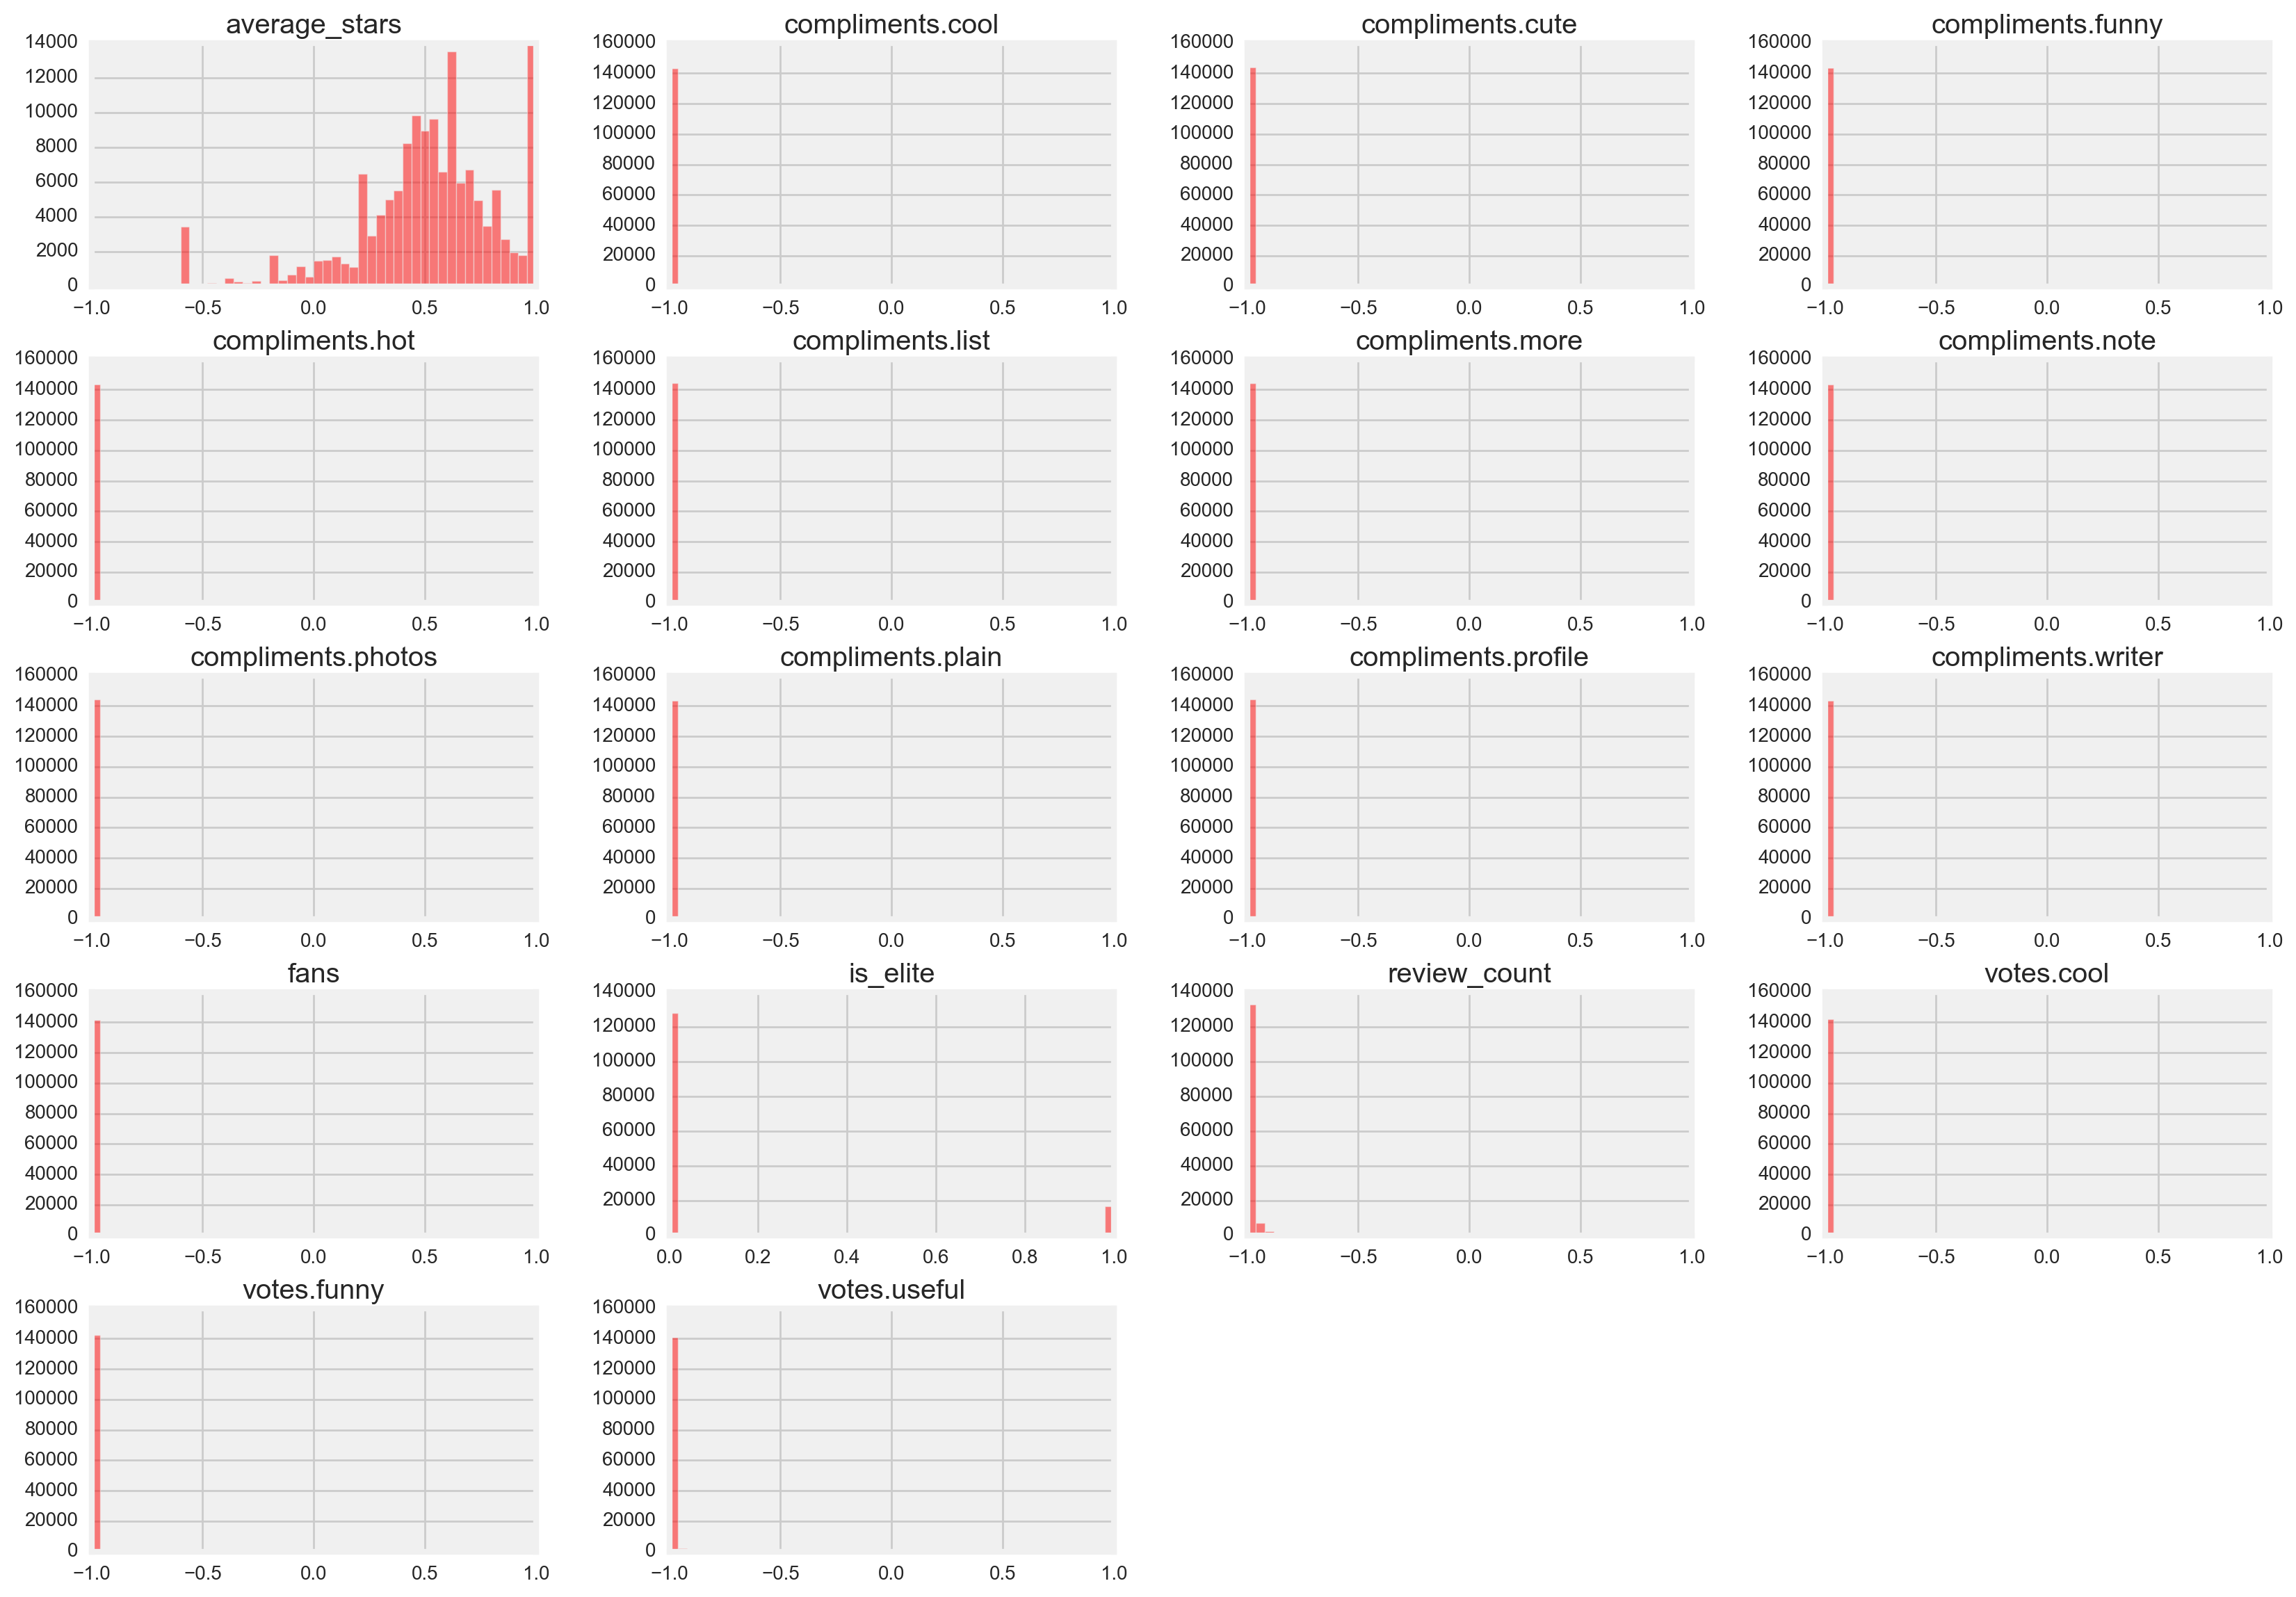

In [41]:
# Distribution of features - after rescaling
users_df2.hist(color='r', alpha=0.5, bins=50, figsize=(18, 14));

In [43]:
# partition dataframe into a design matrix and response vector
x_cols = users_df2.columns[:-1]
X = users_df2[x_cols].values
Y = users_df2['is_elite'].values

In [44]:
print X.shape
print Y.shape

(144206, 17)
(144206,)


In [45]:
# Make Train and Test Datasets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)

In [46]:
# Logistic Regression model
logreg = LogisticRegression()

In [49]:
# instantiate a logistic regression model, and fit with X and y
logreg_model = LogisticRegression()
logreg_model.fit(X, Y)

# check the accuracy on the data set
print logreg_model.score(X, Y)
print
print cross_val_score(logreg_model, X, Y, cv=5)

0.933907049637

[ 0.93533736  0.93495597  0.93221691  0.93117198  0.9295423 ]


In [51]:
# looks like a good model - Baseline score

In [53]:
# evaluate the model by splitting into train and test sets
logreg_model2 = LogisticRegression()
logreg_model2.fit(X_train, y_train)

# check the accuracy on the data set
print logreg_model2.score(X_train, y_train)
print
print cross_val_score(logreg_model2, X_train, y_train, cv=5)

y_pred = logreg_model.predict(X_test)
# accuracy
#validation_score = model.score(X_validation, y_test)
    
# f1_score
validation_score = f1_score(y_test, y_pred, average = "macro")
print validation_score

0.932465933914

[ 0.92918129  0.93065488  0.93052486  0.9317384   0.93147538]
0.796158540499


In [54]:
print y_pred

[0 0 0 ..., 0 0 0]


In [55]:
# generate class probabilities
probs = logreg_model2.predict_proba(X_test)
print probs

[[ 0.90612762  0.09387238]
 [ 0.94991806  0.05008194]
 [ 0.96083268  0.03916732]
 ..., 
 [ 0.96238234  0.03761766]
 [ 0.96753847  0.03246153]
 [ 0.95187055  0.04812945]]


In [62]:
# generate evaluation metrics
print metrics.accuracy_score(y_test, y_pred)
print metrics.roc_auc_score(y_test, probs[:, 1])

0.934401220442
0.975589726258


<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 4. Find something interesting on your own

---

You want to impress your superiors at Yelp by doing some investigation into the data on your own. You want to do classification, but you're not sure on what.

1. Create a hypothesis or hypotheses about the data based on whatever you are interested in, as long as it is predicting a category of some kind (classification).
2. Explore the data visually (ideally related to this hypothesis).
3. Build one or more classification models to predict your target variable. **Your modeling should include gridsearching to find optimal model parameters.**
4. Evaluate the performance of your model. Explain why your model may have chosen those specific parameters during the gridsearch process.
5. Write up what the model tells you. Does it validate or invalidate your hypothesis? Write this up as if for a non-technical audience.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 5. ROC and Precision-recall

---

Some categories have fewer overall businesses than others. Choose two categories of businesses to predict, one that makes your proportion of target classes as even as possible, and another that has very few businesses and thus makes the target varible imbalanced.

1. Create two classification models predicting these categories. Optimize the models and choose variables as you see fit.
- Make confusion matrices for your models. Describe the confusion matrices and explain what they tell you about your models' performance.
- Make ROC curves for both models. What do the ROC curves describe and what do they tell you about your model?
- Make Precision-Recall curves for the models. What do they describe? How do they compare to the ROC curves?
- Explain when Precision-Recall may be preferable to ROC. Is that the case in either of your models?

## OOP, Stochastic Gradient Descent, and Linear Algebra

---

In this part of the project, you will implement machine learning algorithms we have covered in class from scratch. 

--- 

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 6. Implement the `LinearRegrssion` class using Stochastic Gradient Descent to include the following: 

- An option to regularize the model with Ridge Regression. The method should automatically calculate the best `alpha` for the user. The closed form solution for Ridge Regression may be helpful [Hint: Think of the `n_alphas` parameter in sklearn]


Protip: Compare if your implemenation works by applying it on the Diabetes Dataset and seeing it how it compares to opensource implemenations in `sklearn` and `statsmodels`. 

http://statsmodels.sourceforge.net/devel/examples/#regression

http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 7. Extend the Binary `LogisticRegression` model to implement Multi-class classification that fits the model using Stochastic Gradient Descent. Include the following : 

- Use the program we coded in class that implemented Logistic regression for Binary classification and extend it to implement Multi-class classification 
  - [Binary Logistic regression program](https://github.com/ga-students/DSI-SF-5/blob/master/curriculum/week-04/logistic_regression/Logistic_regression.py)

- An option to regularize the model with Ridge Regression. The method should automatically calculate the best `alpha` for the user. The closed form solution for Ridge Regression may be helpful [Hint: Think of the `n_alphas` parameter in sklear

Check if the results of your `LogisticRegression` implementation matches with the Sklearn implementation: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">
### 8. Singular Value Decomposition 

- Read articles on image compression with SVD and use `numpy` apply it to images from the MNIST Datasets. To get the MNIST Datset, use the following comands. Note that the `mnist` data has shape `(70000, 784)`. You will need to convert it to 28x28 images [Hint: `np.reshape`]. 
       
       from sklearn.datasets import fetch_mldata
       mnist = fetch_mldata('MNIST original', data_home=custom_data_home)

    https://inst.eecs.berkeley.edu/~ee127a/book/login/l_svd_apps_image.html

    http://www.frankcleary.com/svdimage/
    
    
- Apply Logistic Regression to classify MNIST Images. This may require having the images be `784` dimensions rather than `28x28`. Compare results of the classifier on a test set when you apply it on the raw dataset vs. the compressed version of dataset from SVD. 

## Optional: Interview Practice

## Coding Questions 
- Implement Binary Search in Python and write down the algorithmic complexity of the Binary Search Algorithm.


- Implement Merge Sort in Python [Hint: First implement the `merge` function that combines two sorted arrays into one sorted array linear time]. What is the time complexity of `mergesort` ?


- Find the closest pair from two sorted arrays. Given two sorted arrays and a number x, find the pair whose sum is closest to x and the pair has an element from each array. We are given two arrays ar1[0…m-1] and ar2[0..n-1] and a number x, we need to find the pair ar1[i] + ar2[j] such that absolute value of (ar1[i] + ar2[j] – x) is minimum. What is the time complexity of this algorithm?

## Probability  and Statistics Questions 

- In any 15-minute interval, there is a 20% probability that you will see at least one shooting star. What is the probability that you see at least one shooting star in the period of an hour?


- A certain couple tells you that they have two children, at least one of which is a girl. What is the probability that they have two girls?


## Interview Questions Related to Material

- Explain what is bias-variance tradeoff to a non-technical person. Why is it a useful framework? How do you detect bias in your models? How about you variance? 


- Explain why cross-validation is important. 


- What is regularization? What are the advantages/disadvantages of different types of regularization schemes? 


- What are the loss functions associated with linear regression, logistic regression, and KNN? 


- Can you give examples of feature engineering on datasets you have worked with? 